# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample, shuffle

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
# Read in data, replace -999 with NA
df = pd.read_csv("BirdTraitData.csv", encoding = 'unicode_escape', na_values = [-999])

# Investigate columns
df.columns

Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet: invertebrates',
       'Diet: vertebrates', 'Diet: fruits', 'Diet: flower/nectar/pollen/gums',
       'Diet: seeds', 'Diet: other plant materials',
       'Diet: scavenge; garbage; carrion; offal; carcasses', 'TrophicLevel',
       'ActivityCycle', 'ForagingStratum', 'MigratoryStatus', 'IncubationTime',
       'ClutchSize', 'EggLength', 'EggWidth', 'EggMass', 'NestingHabit',
       'MaxLongevity', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid',
       'Alaotra.Mangoro', 'Amoron.i.Mania', 'Analamanga', 'Analanjirofo',
       'Androy', 'Anosy', 'Atsimo.Andrefana', 'Atsimo.Atsinanana',
       'Atsinanana', 'Betsiboka', 'Boeny', 'Bongolava', 'DIANA',
       'Haute.Matsiatra', 'Ihorombe', 'Itasy', 'Melaky', 'Menabe', 'SAVA',
       'Sofia', 'Vakinankaratra', 'Vatovavy.Fitovinany', 'Antananarivo',
       'Antsiranana', 'Fianarantsoa', 'Mahajanga', 'Toamasina', 'Toliara',
 

In [3]:
# Rename columns
df = df.rename(columns={'Diet: invertebrates': 'Diet_Invertebrates',
                       'Diet: vertebrates': 'Diet_Vertebrates',
                       'Diet: fruits': 'Diet_Fruits',
                       'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
                       'Diet: seeds':'Diet_Seeds',
                       'Diet: other plant materials': 'Diet_Plants',
                       'Diet: scavenge; garbage; carrion; offal; carcasses': 'Diet_Other'})

In [4]:
# Select columns
selected_columns = ['AdultBodyMass', 
                    'DietBreadth', 
                    'Diet_Invertebrates', 
                    'Diet_Vertebrates',
                    'Diet_Fruits', 
                    'Diet_Flowers', 
                    'Diet_Seeds', 
                    'Diet_Plants', 
                    'Diet_Other',
                    'TrophicLevel',
                    'ActivityCycle', 
                    'ForagingStratum', 
                    'MigratoryStatus',
                    'IncubationTime', 
                    'ClutchSize', 
                    'EggLength', 
                    'EggWidth',
                    'EggMass', 
                    'NestingHabit',
                    'MaxLongevity',
                    'Subarid']

# Filter df for selected columns
df = df[selected_columns]

In [5]:
df.head()

,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,TrophicLevel,...,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Subarid
0,138.5,2.0,yes,yes,no,no,no,no,no,3.0,...,3.0,no,31.0,3.0,3.85,NaN,NaN,arboreal,NaN,1
1,1050.0,1.0,no,yes,no,no,no,no,no,3.0,...,3.0,no,39.5,2.5,58.50,46.95,NaN,arboreal,NaN,1
2,181.0,2.0,yes,yes,no,no,no,no,no,3.0,...,3.0,no,35.0,2.5,38.35,31.90,NaN,arboreal,NaN,1
3,292.0,2.0,yes,yes,no,no,no,no,no,3.0,...,3.0,no,31.0,1.5,43.70,35.20,29.1,arboreal,NaN,1
4,511.0,2.0,yes,yes,no,no,no,no,no,3.0,...,4.0,no,35.5,2.0,54.50,45.00,NaN,arboreal,144.0,1


### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [6]:
# Recode categorical predictors to integers
le = LabelEncoder()
categorical = df.select_dtypes(include = ['object'])

for column in categorical:
    df[column] = le.fit_transform(df[column])
    
df.head()

,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,TrophicLevel,...,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Subarid
0,138.5,2.0,1,1,0,0,0,0,0,3.0,...,3.0,0,31.0,3.0,3.85,NaN,NaN,1,NaN,1
1,1050.0,1.0,0,1,0,0,0,0,0,3.0,...,3.0,0,39.5,2.5,58.50,46.95,NaN,1,NaN,1
2,181.0,2.0,1,1,0,0,0,0,0,3.0,...,3.0,0,35.0,2.5,38.35,31.90,NaN,1,NaN,1
3,292.0,2.0,1,1,0,0,0,0,0,3.0,...,3.0,0,31.0,1.5,43.70,35.20,29.1,1,NaN,1
4,511.0,2.0,1,1,0,0,0,0,0,3.0,...,4.0,0,35.5,2.0,54.50,45.00,NaN,1,144.0,1


### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [7]:
# Select features and target
X = df[['AdultBodyMass', 
                    'DietBreadth', 
                    'Diet_Invertebrates', 
                    'Diet_Vertebrates',
                    'Diet_Fruits', 
                    'Diet_Flowers', 
                    'Diet_Seeds', 
                    'Diet_Plants', 
                    'Diet_Other',
                    'TrophicLevel',
                    'ActivityCycle', 
                    'ForagingStratum', 
                    'MigratoryStatus',
                    'IncubationTime', 
                    'ClutchSize', 
                    'EggLength', 
                    'EggWidth',
                    'EggMass', 
                    'NestingHabit',
                    'MaxLongevity']]
y = df['Subarid']

# Split the data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 808)


In [8]:
# Initialize Bagging Classifier
bagging = BaggingClassifier(
        random_state = 808,
        oob_score = True,
        n_estimators = 100, # number of trees
        bootstrap = True) 

# Fit model to data
bagging.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [9]:
# Predict values for test set
bagging_preds = bagging.predict(X_test)

# Calculate OOB score
oob_score = bagging.oob_score_
print(f'OOB score: {oob_score:.3f}')

# Compute model accuracy
bagging_accuracy = accuracy_score(y_test, bagging_preds)
print(f'Bagging Accuracy Score: {bagging_accuracy:.3f}')

OOB score: 0.882
Bagging Accuracy Score: 0.945


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

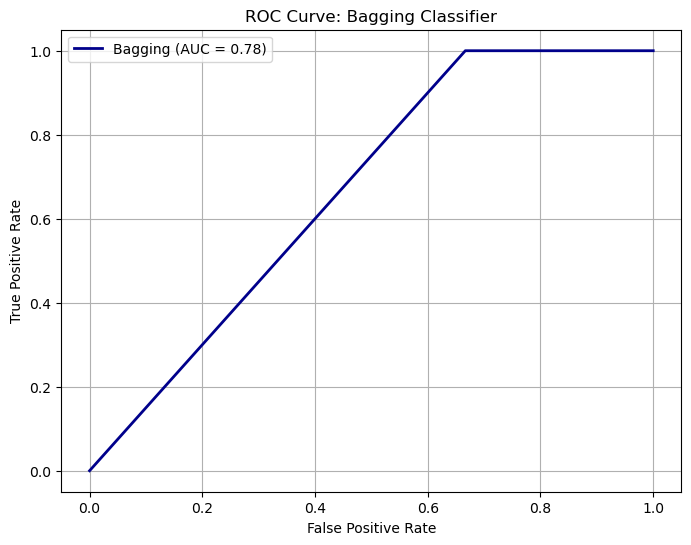

In [10]:
# Set up for ROC curve
fpr, tpr, _ = roc_curve(y_test, bagging_preds)

y_pred_prob = bagging.predict_proba(X_test)[:, 1]
roc_auc_bagging = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, color = 'darkblue', lw = 2, label = f'Bagging (AUC = {roc_auc_bagging:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Bagging Classifier')
plt.legend()
plt.grid(True)
plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

The ROC curve doesn't appear very steep, as is desired to generate a higher AUC score. A shallow curve is telling us that the False Positive (FP) rate is nearly the same as the True Positive (TP) rate. However, the accuracy metric is telling us that the model is performing well on the testing data. This disparity could be the result of a class imbalance. If the model is predicting the majority class correctly most of the time, it can give us both a high accuracy score and a high TP score. The few times it encounters a minority class (0) it will likely guess the majority class (1) which is wrong, generating a high FP score. The similarity in these scores is generating this shallow curve.  

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [11]:
# Identify majority class 
class_counts = df.Subarid.value_counts()
print(f'Class 0: {class_counts[0]}')
print(f'Class 1: {class_counts[1]}')

# Separate majority and minority classes
X_train_majority = X_train[y_train == 1]
X_train_minority = X_train[y_train == 0]
y_train_majority = y_train[y_train == 1]
y_train_minority = y_train[y_train == 0]

# Calculate ratio of majority to minority class
ratio = class_counts[1]/class_counts[0]
print(f'Ratio of majority to minority class: {ratio}')

# Upsample the minority class
X_train_minority_upsampled = resample(X_train_minority, 
                                 replace=True,    
                                 n_samples=len(X_train_majority),    
                                 random_state=808)

y_train_minority_upsampled = resample(y_train_minority, 
                                 replace=True,    
                                 n_samples=len(y_train_majority),    
                                 random_state=808)

# Combine majority and upsampled minority class
X_train_upsampled = pd.concat([X_train_minority_upsampled, X_train_majority])
y_train_upsampled = pd.concat([y_train_minority_upsampled, y_train_majority])

# Shuffle the dataset
X_train_bal = shuffle(X_train_upsampled, random_state=808)
y_train_bal = shuffle(y_train_upsampled, random_state = 808)

# Print value counts 
print(y_train_bal.value_counts())

Class 0: 25
Class 1: 217
Ratio of majority to minority class: 8.68
Subarid
1    150
0    150
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

Balanced OOB score: 0.940
Balanced Bagging Accuracy Score: 0.890


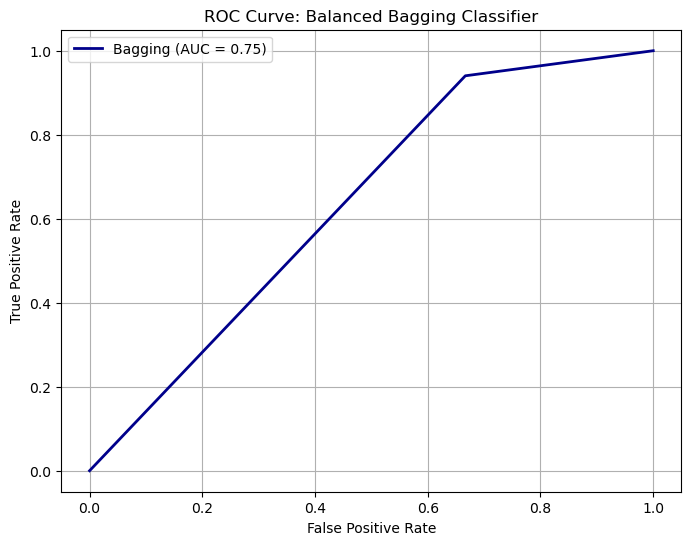

In [12]:
# Initialize Bagging Classifier
bagging_bal = BaggingClassifier(
        random_state = 808,
        oob_score = True,
        n_estimators = 100, # number of trees
        bootstrap = True) 

bagging_bal.fit(X_train_bal, y_train_bal)

bagging_preds_bal = bagging_bal.predict(X_test)

oob_score_bal = bagging_bal.oob_score_
print(f'Balanced OOB score: {oob_score_bal:.3f}')

bagging_accuracy_bal = accuracy_score(y_test, bagging_preds_bal)
print(f'Balanced Bagging Accuracy Score: {bagging_accuracy_bal:.3f}')

# ROC curve
fpr_bal, tpr_bal, _ = roc_curve(y_test, bagging_preds_bal)

y_pred_prob_bal = bagging_bal.predict_proba(X_test)[:, 1]
roc_auc_bagging_bal = roc_auc_score(y_test, y_pred_prob_bal)

# Plot ROC curve
plt.figure(figsize = (8,6))
plt.plot(fpr_bal, tpr_bal, color = 'darkblue', lw = 2, label = f'Bagging (AUC = {roc_auc_bagging_bal:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Balanced Bagging Classifier')
plt.legend()
plt.grid(True)
plt.show()

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

The second model (using the balanced data) increased the OOB score from 0.882 to 0.940 but the accuracy score decreased from 0.945 to 0.890. Additionally, the AUC score decreased from 0.78 to 0.75. An increase in OOB score means the model's performance on *training* data has gotten better, but its decrease in accuracy means its performance on the *testing* data has gotten worse. Since the AUC score also decreases, it is very likely the model is overfitting and not generalizing well to the unseen test data. Upscaling proved to not be useful.

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [13]:
# Calculate permutation importance
result = permutation_importance(bagging, X_test, y_test, n_repeats=10, random_state=808)

# Match feature names to coefficients
for feature, importance in zip(X_test.columns, result.importances_mean):
    print(f'{feature}: {importance:.4f}')

AdultBodyMass: 0.0082
DietBreadth: 0.0000
Diet_Invertebrates: 0.0000
Diet_Vertebrates: 0.0000
Diet_Fruits: 0.0027
Diet_Flowers: 0.0000
Diet_Seeds: 0.0000
Diet_Plants: 0.0027
Diet_Other: 0.0000
TrophicLevel: 0.0055
ActivityCycle: 0.0123
ForagingStratum: 0.0041
MigratoryStatus: 0.0000
IncubationTime: -0.0082
ClutchSize: 0.0014
EggLength: 0.0041
EggWidth: 0.0041
EggMass: 0.0000
NestingHabit: 0.0260
MaxLongevity: 0.0068


What features are most important in our model of species distribution?

The most important features with the highest means include `NestingHabit` and `ActivityCycle`.